# Import libraries, Load Data

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')
#comment

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
import yfinance as yf
from numpy import linalg as LA
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import coint
from itertools import combinations

In [6]:
price_path = '/Users/tuckeringlefield/Desktop/FinanceData/price_data_from_shardar.csv'
cap_path = '/Users/tuckeringlefield/Desktop/FinanceData/cap_data_from_shardar.csv'
prices_df = pd.read_csv(price_path, index_col='date')
caps_df = pd.read_csv(cap_path, index_col='date')

In [7]:
# Convert dates to datetime
prices_df.index = pd.to_datetime(prices_df.index)

# Get the initial start and end date
start_date = prices_df.index[0]
end_date = prices_df.index[89]

spy_data = yf.download('SPY', start=start_date, end=end_date, interval='1d')
spy_data = pd.DataFrame(spy_data["Adj Close"])
spy_data.rename({"Adj Close": 'SPY'}, inplace=True, axis=1)
spy_data = spy_data.reindex(prices_df.index)
prices_with_market = pd.concat([prices_df, spy_data], axis=1)

df_diff = prices_with_market.diff().dropna()

[*********************100%%**********************]  1 of 1 completed


In [8]:
print(len(prices_with_market))
print(len(df_diff))

5787
0


# Outline and Function Definitions

Outline:

We want to start from the year 2000 and do our analysis in two periods:

- Learning Period

This will require 3 months of data. The top ten largest market cap stocks will be calculated. We should check for null values, this will let us know what stocks were recently added. We can then remove/add stocks by relevency. We then should calculate the correlation matrix for these stocks off of the last day of the three months. Then we will do k means clustering to find pairs that are cointegrated based of off the ADF.

- Testing Period

This will operate on two weeks of data. We will look at the spread between the stocks. If the spread goes more than 2 std deviations away from the mean for the correlation matrix period we will suggest opening a trade. Spread will come from the linear regression coefficient.

### Functions

In [9]:
# Function to find the top ten largest market cap stocks
def find_top_ten(dataframe, date_start, date_end):
    # Filter dataframe over the desired 3 months
    filtered_data = dataframe.loc[date_start:date_end]
    end_date_dt = pd.to_datetime(date_end)
    target_date = (end_date_dt + pd.DateOffset(1)).date().strftime('%Y-%m-%d')
    selected_row = caps_df.loc[target_date]
    selected_row_no_null = selected_row.dropna()
    stocks_list = selected_row_no_null.nlargest(10).index.tolist()
    return stocks_list

In [10]:
# Function to check for null values
def check_top_ten(dataframe, date_start, date_end, stocks_list):
    #should find the average and median ammount of null values per column
    #print this out and print out top ten col's ammounts
    ammount_null = []
    for column in df.columns:
        num_null = df[column].isnull().sum()
        ammount_null.append(num_null)
    average_num_null = np.mean(ammount_null)
    median_num_null = np.median(ammount_null)
    plt.boxplot(ammount_null, vert=False)
    plt.title('Boxplot of null values per stock in time period')
    plt.show()
    print("Checking Stocks List")
    print("--------------------")
    for column in stocks_list:
        num_null = df[column].isnull().sum()
        print(f'Stock: {column}, Num null: {num_null}')

In [11]:
# Function to filter the DF
def filter_diff_df(dataframe, date_start, date_end, stocks_list):
    desired_columns = stocks_list.copy()
    desired_columns.append("SPY")
    print(desired_columns)
    filtered_df = dataframe[desired_columns]
    filtered_df = filtered_df[date_start:date_end].diff().dropna()
    return filtered_df

In [12]:
def filter_df_by_dates(dataframe, date_start, date_end, stocks_list):
    desired_columns = stocks_list.copy()
    desired_columns.append("SPY")
    print(desired_columns)
    filtered_df = dataframe[desired_columns]
    filtered_df = filtered_df[date_start:date_end]
    return filtered_df

In [13]:
# Function to calculate the betas
def calculate_betas(dataframe, date_start, date_end, stocks_list):
    df = dataframe[(dataframe.index >= date_start) & (dataframe.index <= date_end)]
    beta_values = []
    columns = []

    df_var = df['SPY'].var()

    for stk in stocks_list:
        df_cov = df[[stk, 'SPY']].cov().loc[stk, 'SPY']
        beta = df_cov / df_var
        beta_values.append(beta)
        columns.append(stk + '_beta')

    beta_df = pd.DataFrame([beta_values], columns=columns)
    beta_df.index = df.index[:1]

    plt.figure(figsize=(12, 4))
    sns.boxplot(data=beta_df)
    plt.show()

    return beta_df

In [14]:
# Function to calculate the residuals
def calculate_residuals(df, stocks_list):
    res_df = pd.DataFrame()
    for stk in stocks_list:
        res_df[stk] = df[stk]-df[stk+"_beta"]*df["SPY"]
    return res_df

In [15]:
# Function to cluster the matrix
def cluster_the_matrix(df, num_clusters):
    A = abs(df.corr().values)
    print(f'A Shape: {A.shape}')
    D = np.diag(A.sum(axis=1))
    print(f'D Shape: {D.shape}')
    L = D - A
    print(f'L Shape: {L.shape}')
    eigenvalues, eigenvectors = LA.eig(L)
    X = eigenvectors[:,:num_clusters]
    print(f'X Shape: {X.shape}')
    kmeans = KMeans(n_clusters=num_clusters, random_state=2, n_init=20).fit(X)
    print("Kmeans Labels:")
    print(kmeans.labels_)
    print(df.columns)

    cluster_dict = {}

    # Iterate over the indices of cluster_list
    for i in range(len(kmeans.labels_)):
        cluster_number = kmeans.labels_[i]
        stock_name = df.columns[i]

        # Check if cluster_number is already a key in the dictionary
        if cluster_number in cluster_dict:
            cluster_dict[cluster_number].append(stock_name)
        else:
            cluster_dict[cluster_number] = [stock_name]

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    scatter = ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
    unique_labels = {label: idx for idx, label in enumerate(set(kmeans.labels_))}
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(value)), markersize=10)
           for value in unique_labels.values()]
    labels = unique_labels.keys()
    ax.legend(handles, labels, title="Clusters", loc="best", bbox_to_anchor=(1, 1))
    ax.set_title(f'K-Means Clustering Results with K={num_clusters}')
    plt.show()

    return cluster_dict


In [16]:
# Function to find the cointegrated pairs
def find_cointegrated_pairs(dataframe, cluster_dict, sig_level):
    cointegrated_pairs = []
    for cluster_num, stocks in cluster_dict.items():
      for stock1, stock2 in combinations(stocks, 2):
          pvalue1 = coint(dataframe[stock1], dataframe[stock2])[1]
          pvalue2 = coint(dataframe[stock2], dataframe[stock1])[1]
          if pvalue1 < sig_level and pvalue2 < sig_level:
              cointegrated_pairs.append((stock1, stock2))
    return cointegrated_pairs

In [17]:
# Function to check on existing pairs
def is_still_conintegrated(dataframe, pair, sig_level):
    stock1 = pair[0]
    stock2 = pair[1]
    pvalue1 = coint(dataframe[stock1], dataframe[stock2])[1]
    pvalue2 = coint(dataframe[stock2], dataframe[stock1])[1]
    if pvalue1 < sig_level and pvalue2 < sig_level:
        return True
    return False

In [18]:
# weekly function to calculate the beta of the pair
def calculate_beta_for_pair(dataframe, pair):
    asst1 = pair[0]
    asst2 = pair[1]

    train = dataframe[[asst1, asst2]]

    beta = train.cov().iloc[0, 1]/train[asst2].var()
    return beta

In [19]:
# Function to get the spread data
def get_spread_limits_for_past_months(dataframe, pair, beta):
    asst1 = pair[0]
    asst2 = pair[1]
    asst1_mean = dataframe[asst1].mean() 
    asst2_mean = dataframe[asst2].mean() 
    spread_data = None
    order = []
    if asst1_mean > asst2_mean:
        spread_data = dataframe[asst1]-beta*dataframe[asst2]
        order = [asst1, asst2]
    else:
        spread_data = dataframe[asst2]-beta*dataframe[asst1]
        order = [asst2, asst1]
    mean = spread_data.mean()
    std_dev = spread_data.std()
    lower_limit = mean - (2*std_dev)
    upper_limit = mean + (2*std_dev)
    
    return upper_limit, lower_limit, order
    

In [47]:
# Monitor a pair for a week

def monitor_pair_for_week(dataframe, start_date_index, end_date_index, curr_week_start_index, pair, pair_vals_list):
    #[ still_consecutive, [start_dates], [end_date], [[days_to_open_trade]] ]
    global prices_with_market
    start_date_string = prices_with_market.index[start_date_index].strftime('%Y-%m-%d')
    end_date_string = prices_with_market.index[end_date_index].strftime('%Y-%m-%d')
    curr_week_date_string = prices_with_market.index[curr_week_start_index].strftime('%Y-%m-%d')
    forward_three_months_data = dataframe[start_date_index+7 : end_date_index]
    print('____________________________________________________________________')
    print(forward_three_months_data.tail())
    
    if pair_vals_list[0] == True:
        past_three_month_data = dataframe[start_date_index : curr_week_start_index]
        beta_past_three_months = calculate_beta_for_pair(past_three_month_data, pair)
        upper, lower , pair_order = get_spread_limits_for_past_months(past_three_month_data, pair, beta_past_three_months)
        curr_week_data = dataframe.tail(7)
        curr_week_spread_data = curr_week_data[pair_order[0]]-beta_past_three_months*curr_week_data[pair_order[1]]
        for index, value in zip(curr_week_spread_data.index, curr_week_spread_data.values):
            date = index.strftime('%Y-%m-%d')
            if (value >= upper or value <= lower):
                index_to_insert_at = len(pair_vals_list[1]) - 1
                pair_vals_list[-1][index_to_insert_at].append(date)
  
    is_coint = is_still_conintegrated(forward_three_months_data, pair , sig_level=0.05)
    if is_coint:
        if pair_vals_list[0] == False:
            pair_vals_list[1].append(curr_week_date_string)
            pair_vals_list[0] = True
    else:
        if pair_vals_list == True:
            pair_vals_list[0] = False
            pair_vals_list[2].append(curr_week_date_string)

    return pair_vals_list

In [39]:
def monitor_group_of_pairs(dataframe, pair_dict, stop_after_weeks):
    coint_dict = pair_dict.copy()
    weeks_running = 0
    while(weeks_running < stop_after_weeks):
        # On the first week we don't have any previous data in the pair_dict What do we pass in??? 
        start_date_index = ((weeks_running+1)*7)
        # always add 89 days here
        end_date_index = ((weeks_running+1)*7) + 96
        curr_week_start_index = ((weeks_running+1)*7) + 89
        # Filter the overall df
        three_month_plus_one_week_df = dataframe[start_date_index : end_date_index]
        for key, value in coint_dict.items():
            # end_date = start_date + WEEK            
            result = monitor_pair_for_week(three_month_plus_one_week_df, start_date_index, end_date_index, curr_week_start_index, key, value )
            # Update pair_dict[pair] with result
            coint_dict[key] = result
        # Prepping for the next week...
        # Train by adding the new data in
                        
        # Update cointegrated pairs list
        #found_pairs = find_contintegrated_pairs() 
        default_val_list_for_new_pair = [True, [dataframe.index[start_date_index]],[],[[]]]
        # for item in found_pairs:
            #if coint_dict[item] not in coint_dict:
                #otherwise add it as a new key with the default list
        weeks_running += 1
    return coint_dict

In [22]:
# TODO:

# STD DEVIATION for the spreads?????



# Testing Functions

In [23]:
prices_with_market.head()

,ATW,A,AA,AAAB,AABC,AAC1,AACC,AACE,AACH,AADI,...,ZVOI,ZVRA,ZVUE,ZVXI,ZY,ZYME,ZYNE,ZYXI,ZZ,SPY
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,8.766,44.275,NaN,8.036,7.791,4.562,NaN,17.000,NaN,NaN,...,NaN,NaN,NaN,3.625,NaN,NaN,NaN,NaN,NaN,93.290154
2000-01-04,8.913,40.893,NaN,7.619,7.791,4.438,NaN,15.875,NaN,NaN,...,NaN,NaN,NaN,3.500,NaN,NaN,NaN,NaN,NaN,89.641953
2000-01-05,8.899,37.855,NaN,7.500,7.791,4.438,NaN,16.125,NaN,NaN,...,NaN,NaN,NaN,3.708,NaN,NaN,NaN,NaN,NaN,89.802322
2000-01-06,9.270,36.896,NaN,7.500,7.791,4.500,NaN,16.125,NaN,NaN,...,NaN,NaN,NaN,3.833,NaN,NaN,NaN,NaN,NaN,88.359032
2000-01-07,9.508,39.971,NaN,7.738,7.607,4.562,NaN,16.750,NaN,NaN,...,NaN,NaN,NaN,4.167,NaN,NaN,NaN,NaN,NaN,93.490608


In [24]:
start = prices_with_market.index[0]
end = prices_with_market.index[89]
top_ten = find_top_ten(prices_with_market, start, end)
print(top_ten)
# check_top_ten(df, start, end, top_ten)
# print()

['SCMR', 'LVLT', 'AMAT', 'INTC', 'CSCO', 'JAVA1', 'ORCL', 'DELL1', 'MSFT', 'QCOM']


In [25]:
filtered_diff_df = filter_diff_df(prices_with_market, start, end, top_ten)
filtered_diff_df.head()
three_month_top_10_price_df = filter_df_by_dates(prices_with_market, start, end, top_ten)

['SCMR', 'LVLT', 'AMAT', 'INTC', 'CSCO', 'JAVA1', 'ORCL', 'DELL1', 'MSFT', 'QCOM', 'SPY']
['SCMR', 'LVLT', 'AMAT', 'INTC', 'CSCO', 'JAVA1', 'ORCL', 'DELL1', 'MSFT', 'QCOM', 'SPY']


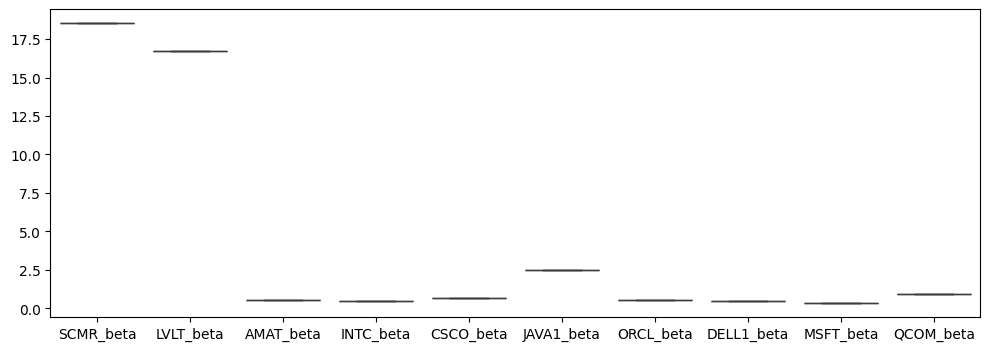

Beta DF:
            SCMR_beta  LVLT_beta  AMAT_beta  INTC_beta  CSCO_beta  JAVA1_beta  \
date                                                                            
2000-01-04  18.534785    16.6979   0.505713    0.47547    0.68421    2.472595   

            ORCL_beta  DELL1_beta  MSFT_beta  QCOM_beta  
date                                                     
2000-01-04   0.508753    0.451124   0.329182   0.901145  

Residual DF:
          SCMR       LVLT      AMAT      INTC      CSCO      JAVA1      ORCL  \
0    18.034621 -27.132703  0.701941  0.566611  0.393136  -0.479478 -0.275966   
1   -38.805421 -36.427840 -1.021101  0.409749  0.166273  -0.146530 -0.942589   
2   -69.081917 -22.850075  0.858890 -1.005758  0.022514  -4.181327 -0.802721   
3    13.220332 -54.636554 -2.411103 -1.504913 -1.477076  -4.938308 -1.093706   
4     9.055299  55.544447  1.589802  0.927501  1.124552  12.831959  2.377826   
..         ...        ...       ...       ...       ...        ...       ...   

In [26]:
beta_df = calculate_betas(filtered_diff_df, start, end, top_ten)
print('Beta DF:')
print(beta_df)
print()

merged_df = filtered_diff_df.merge(beta_df, how = 'cross')

print('Residual DF:')
res_df = calculate_residuals(merged_df, top_ten)
print(res_df)

A Shape: (10, 10)
D Shape: (10, 10)
L Shape: (10, 10)
X Shape: (10, 4)
Kmeans Labels:
[1 1 2 1 0 3 1 1 1 1]
Index(['SCMR', 'LVLT', 'AMAT', 'INTC', 'CSCO', 'JAVA1', 'ORCL', 'DELL1',
       'MSFT', 'QCOM'],
      dtype='object')


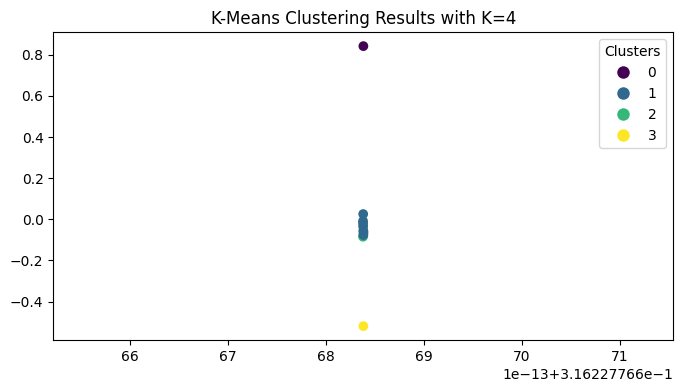

In [27]:
cluster_dictionary_for_top_10 = cluster_the_matrix(res_df, 4)

In [28]:
coint_pairs_from_top_10 = find_cointegrated_pairs(three_month_top_10_price_df, cluster_dictionary_for_top_10, 0.05)
coint_pairs_from_top_10

[('INTC', 'ORCL')]

In [29]:
pair_dict = {
        # [ still_consecutive, [start_dates], [end_date], times_correct, weeks_counted, curr_accuracy, [accuracy] ]
        ('INTC', 'ORCL') : [ True, ['2000-04-4'], [], 0, 0, 0, [] ]
    }

In [30]:
three_month_top_10_price_df['ORCL']

date
2000-01-03    24.208
2000-01-04    22.076
2000-01-05    21.215
2000-01-06    19.678
2000-01-07    21.195
               ...  
2000-05-04    30.439
2000-05-05    31.488
2000-05-08    29.644
2000-05-09    29.517
2000-05-10    27.725
Name: ORCL, Length: 90, dtype: float64

In [31]:
three_month_top_10_price_df['INTC']

date
2000-01-03    25.042
2000-01-04    23.874
2000-01-05    24.360
2000-01-06    22.668
2000-01-07    23.603
               ...  
2000-05-04    34.445
2000-05-05    35.539
2000-05-08    33.869
2000-05-09    33.667
2000-05-10    30.557
Name: INTC, Length: 90, dtype: float64

In [32]:
asst1 = 'ORCL'
asst2 = 'INTC'

train = three_month_top_10_price_df[[asst1, asst2]]

beta = train.cov().iloc[0, 1]/train[asst2].var()
train_spread = train[asst1]-beta*train[asst2]
#test_spread = test[asst1]-beta*test[asst2]

print(train_spread)

date
2000-01-03   -0.123972
2000-01-04   -1.121089
2000-01-05   -2.454310
2000-01-06   -2.347284
2000-01-07   -1.738773
                ...   
2000-05-04   -3.029365
2000-05-05   -3.043346
2000-05-08   -3.264696
2000-05-09   -3.195424
2000-05-10   -1.965603
Length: 90, dtype: float64


In [33]:
days_to_monitor = 7

whole_data = prices_with_market[[asst1,asst2]]
print(whole_data.head())
print()

date_to_start = whole_data.index[89]
for day in range(days_to_monitor):
    current_date = pd.to_datetime(whole_data.index[89 + day]).strftime("%Y-%m-%d")
    day_df = whole_data.loc[current_date]
    train_spread = day_df[asst1]-beta*day_df[asst2]
    print(train_spread)


              ORCL    INTC
date                      
2000-01-03  24.208  25.042
2000-01-04  22.076  23.874
2000-01-05  21.215  24.360
2000-01-06  19.678  22.668
2000-01-07  21.195  23.603

-1.9656030991385762
-2.6770280125542634
-1.76693316240042
-1.482613516084708
-1.6475948228379096
-2.4219622725933476
-4.720263225662265


In [53]:
pair_dict = {
        # [ still_consecutive, [start_dates], [end_date] weeks_counted, [[days_to_open_trade]] ]
        ('INTC', 'ORCL') : [ True, ['2000-04-4'], [], [[]] ]
    }
monitor_group_of_pairs(prices_with_market, pair_dict, 20)
# We know it's working right but we are corcerned about the is_coint function elimating possible trade days?



____________________________________________________________________
               ATW       A  AA   AAAB   AABC  AAC1  AACC    AACE  AACH  AADI  \
date                                                                           
2000-05-23  14.142  35.666 NaN  5.357  5.889   NaN   NaN  15.000   NaN   NaN   
2000-05-24  13.520  36.281 NaN  5.476  5.950   NaN   NaN  15.125   NaN   NaN   
2000-05-25  13.370  42.277 NaN  5.952  6.196   NaN   NaN  14.938   NaN   NaN   
2000-05-26  12.895  39.971 NaN  5.595  6.196   NaN   NaN  13.062   NaN   NaN   
2000-05-30  12.864  46.354 NaN  5.655  5.950   NaN   NaN  14.312   NaN   NaN   

            ...  ZVOI  ZVRA  ZVUE   ZVXI  ZY  ZYME  ZYNE  ZYXI  ZZ  SPY  
date        ...                                                          
2000-05-23  ...   NaN   NaN   NaN  4.250 NaN   NaN   NaN   NaN NaN  NaN  
2000-05-24  ...   NaN   NaN   NaN  4.042 NaN   NaN   NaN   NaN NaN  NaN  
2000-05-25  ...   NaN   NaN   NaN  4.000 NaN   NaN   NaN   NaN NaN  NaN  


ValueError: zero-size array to reduction operation maximum which has no identity